#**MonReader**

**Background:**

Our company develops innovative Artificial Intelligence and Computer Vision solutions that revolutionize industries. Machines that can see: We pack our solutions in small yet intelligent devices that can be easily integrated to your existing data flow. Computer vision for everyone: Our devices can recognize faces, estimate age and gender, classify clothing types and colors, identify everyday objects and detect motion. Technical consultancy: We help you identify use cases of artificial intelligence and computer vision in your industry. Artificial intelligence is the technology of today, not the future.

MonReader is a new mobile document digitization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

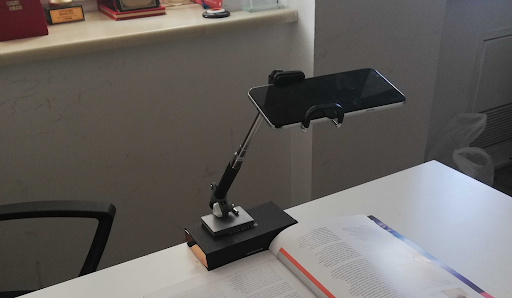

MonReader is a new mobile document digitalization experience for the blind, for researchers and for everyone else in need for fully automatic, highly fast and high-quality document scanning in bulk. It is composed of a mobile app and all the user needs to do is flip pages and everything is handled by MonReader: it detects page flips from low-resolution camera preview and takes a high-resolution picture of the document, recognizing its corners and crops it accordingly, and it dewarps the cropped document to obtain a bird's eye view, sharpens the contrast between the text and the background and finally recognizes the text with formatting kept intact, being further corrected by MonReader's ML powered redactor.

In [68]:
import cv2
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from google.colab import files
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.simplefilter(action='ignore')


import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Flatten, Dense, Activation, MaxPooling2D, InputLayer
from keras.layers import Conv2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import LeakyReLU, ReLU
from keras.models import Sequential, Model
from keras.optimizers import adam_v2, gradient_descent_v2
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.framework import ops
from keras import backend as K

We will import the image files from my Google Drive due to the size of the files.

In [ ]:
from google.colab import drive
drive.mount('content/drive/MyDrive')

Mounted at /content/drive


**Image preprocessing**

We will create an image preprocessing function below.  We will want to make sure that all of the images are the same size and we will use intercubic interpolation with the cv2 package because it produces smoother images when speed is not an issue.  I am using Google Colab's TPU's during runtime.  The add Weighted function will "blend" the images and helps with processing the images due to adjustment of gradients when delivered to a convolutional neural network.  The bitwise_not function will invert the "on" and "off" pixels making the zero pixels black and anything above zero will be converted relationally. This will illuminate to the user what the model is actually looking for and darken surrounding areas. 

In [2]:
def image_preprocessing(path):
    # Create an empty list to store preprocessed images
    images = []
    
    for i in path:
        
        img = cv2.imread(i)
        # Adjust size so all images have the same size
   
        img = cv2.resize(img, dsize = (70,140), interpolation=cv2.INTER_CUBIC)
        
        y,h,x,w = 0,100,0,70
        img = img[y:y+h, x:x+w]

        # Adjust brightness, contrast
        alpha=1.5
        beta=0.5
        img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
        # Normalize the images by reverting the images 
        img = cv2.bitwise_not(img)
        img = img/255

       
        images.append(img)
     
    return images

We will now assign a path to the image folders so that we can iterate over all of the image files.

In [3]:
training_flip_path = glob.glob("drive/My Drive/train_flip/*.jpg")

train_notflip_path = glob.glob("drive/My Drive/train_notflip/*.jpg")

test_flip_path = glob.glob("drive/My Drive/test_flip/*.jpg")

test_notflip_path = glob.glob("drive/My Drive/test_notflip/*.jpg")

In [4]:
train_flip = image_preprocessing(training_flip_path)

In [5]:
train_flip[0].shape

(100, 70, 3)

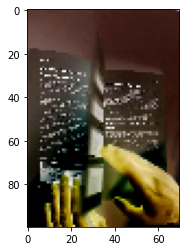

In [6]:
plt.imshow(train_flip[0])

This clearly looks like a page is being flipped so we are ready to look at images in the other folders.

In [7]:
train_notflip = image_preprocessing(train_notflip_path)

test_flip = image_preprocessing(test_flip_path)

test_notflip = image_preprocessing(test_notflip_path)

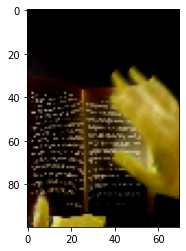

In [8]:
plt.imshow(train_notflip[0])

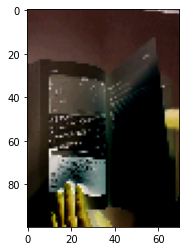

In [9]:
plt.imshow(test_flip[0])

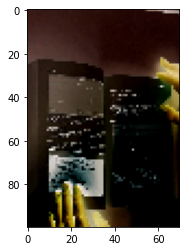

In [10]:
plt.imshow(test_notflip[0])

This one is interesting because it appears as if a page is about to be flipped but is in the test set for not flipped images. More on this later. Let's make sure that this image is a numpy array to be read by a neural network.

In [11]:
type(test_notflip[0])

numpy.ndarray

**Assigning labels**

In [12]:
train_flip_label = np.repeat(1,len(train_flip))
train_notflip_label = np.repeat(0,len(train_notflip))
test_flip_label = np.repeat(1,len(test_flip))
test_notflip_label = np.repeat(0,len(test_notflip))

We will concatenate the training and test sets together for flipped and not flipped sets so that concatenated labels can be attached to them.

597
597
1


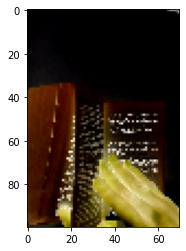

In [13]:
trainX = train_flip + train_notflip    # combining both classes of training data (X input)
trainY = np.concatenate((train_flip_label,train_notflip_label))  # combine the training labels (Y output)

testX = test_flip + test_notflip  # combining both classes of testing data (X input)
testY = np.concatenate((test_flip_label,test_notflip_label))   # combine the testing labels (Y output)
print(len(testX))
print(len(testY))
plt.imshow(testX[100])
print(testY[100])

In [14]:
type(test_notflip)

list

test_notflip[0] is an array but the test_notflip variable itself is a list of arrays.  Below, we will convert trainX and testX into arrays to be compatible with our neural network.

In [15]:
trainX = np.array(trainX)
testX = np.array(testX)
type(trainX)

numpy.ndarray

Now, we will define a function that constructs our convolutional neural network in keras.  If 
the inputs to each layer have a nice, reliable distribution of values, the network can train more easily. Putting the normalization after pooling allows for this to happen but we will normalize first after the input layer.  Batch normalization reduces the epochs needed for training stabilizes the learning process of the neural network.  Max pooling is a downsampling process that uses the maximum value for patches of features so that it does not matter where in the image the pixels actually are.  Dropout layers are added to prevent overfitting by randomly assigning zero values to inputs.  Dense layers are added as they receive all neurons from the previous layer.  We will utilize the Adam optimizer which is a replacement optimization algorithm for stochastic gradient descent.  Adam employs individual adaptive learning rates for different parameters from estimates of the first and second moments of gradients. It is ideal for sparse gradients or "noisy" problems. You can learn more about Adam [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/).

In [16]:
def nn_model():
    # The input_shape needs to accocmodate the upscaled resolution. We will see this in the first layer.
    model = Sequential()
    # Convolutions
    model.add(Conv2D(filters=32,kernel_size=(11, 11),activation = 'relu', kernel_initializer='he_uniform',padding='same',input_shape=(100,70,3)))  
    model.add(BatchNormalization())  # normalizes the distortions reducing epochs needed for training.
    model.add(MaxPooling2D(pool_size=(2,2)))   # pools the information for downsampling
    model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))   #second kernel
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3,3)))

    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"))   #third kernel
    model.add(BatchNormalization())
    model.add(Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"))   #fourth kernel
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    
    model.add(Flatten()) #converts to one dimension


    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    # the output layer must equate the number of classes
    model.add(Dense(1, activation='sigmoid'))

    # initiate optimizer
    opt = adam_v2.Adam(lr=0.001)

    # Let's train the model using the chosen optimizer
    model.compile(loss='binary_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])
    return model

Importing matplotlib inline and other packages to make graphs larger and more visually appealing.

In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 180

Next, we will define functions to implement k-fold cross-validation to further reduce the chance of overfitting and plot the performance of the above neural network model.  

In [18]:
def evaluate_model(dataX, dataY, n_folds=5):  
	scores, histories = list(), list()
	# prepare cross validation
    
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumerate splits
	for train_ix, test_ix in kfold.split(dataX):
		# define model
		model = nn_model()
		# select rows for train and test sets
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# fit model
		history = model.fit(trainX, trainY, epochs=25, batch_size=128, validation_data=(testX, testY), verbose=0)
		# evaluate model
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# store scores
		scores.append(acc)
		histories.append(history)
	return scores, histories
 
# plot diagnostic learning curves
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# plot loss
		plt.subplot(2, 1, 1)
		plt.title('Binary Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# plot accuracy
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
		plt.tight_layout(pad=3.0)
	plt.show()
 
# summarize model performance
def summarize_performance(scores):
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
	plt.boxplot(scores)
	plt.show()

We will now add all three functions to one results function and call on it.

In [19]:
def results():
	values= []
	# load dataset
	scores, histories = evaluate_model(trainX, trainY)
	# learning curves
	values.append(scores)
	summarize_diagnostics(histories)
	# summarize estimated performance
	summarize_performance(scores)
	print('The overall accuracy is :'+str(np.mean(values)))

> 88.935
> 89.562
> 88.912
> 98.536
> 97.280


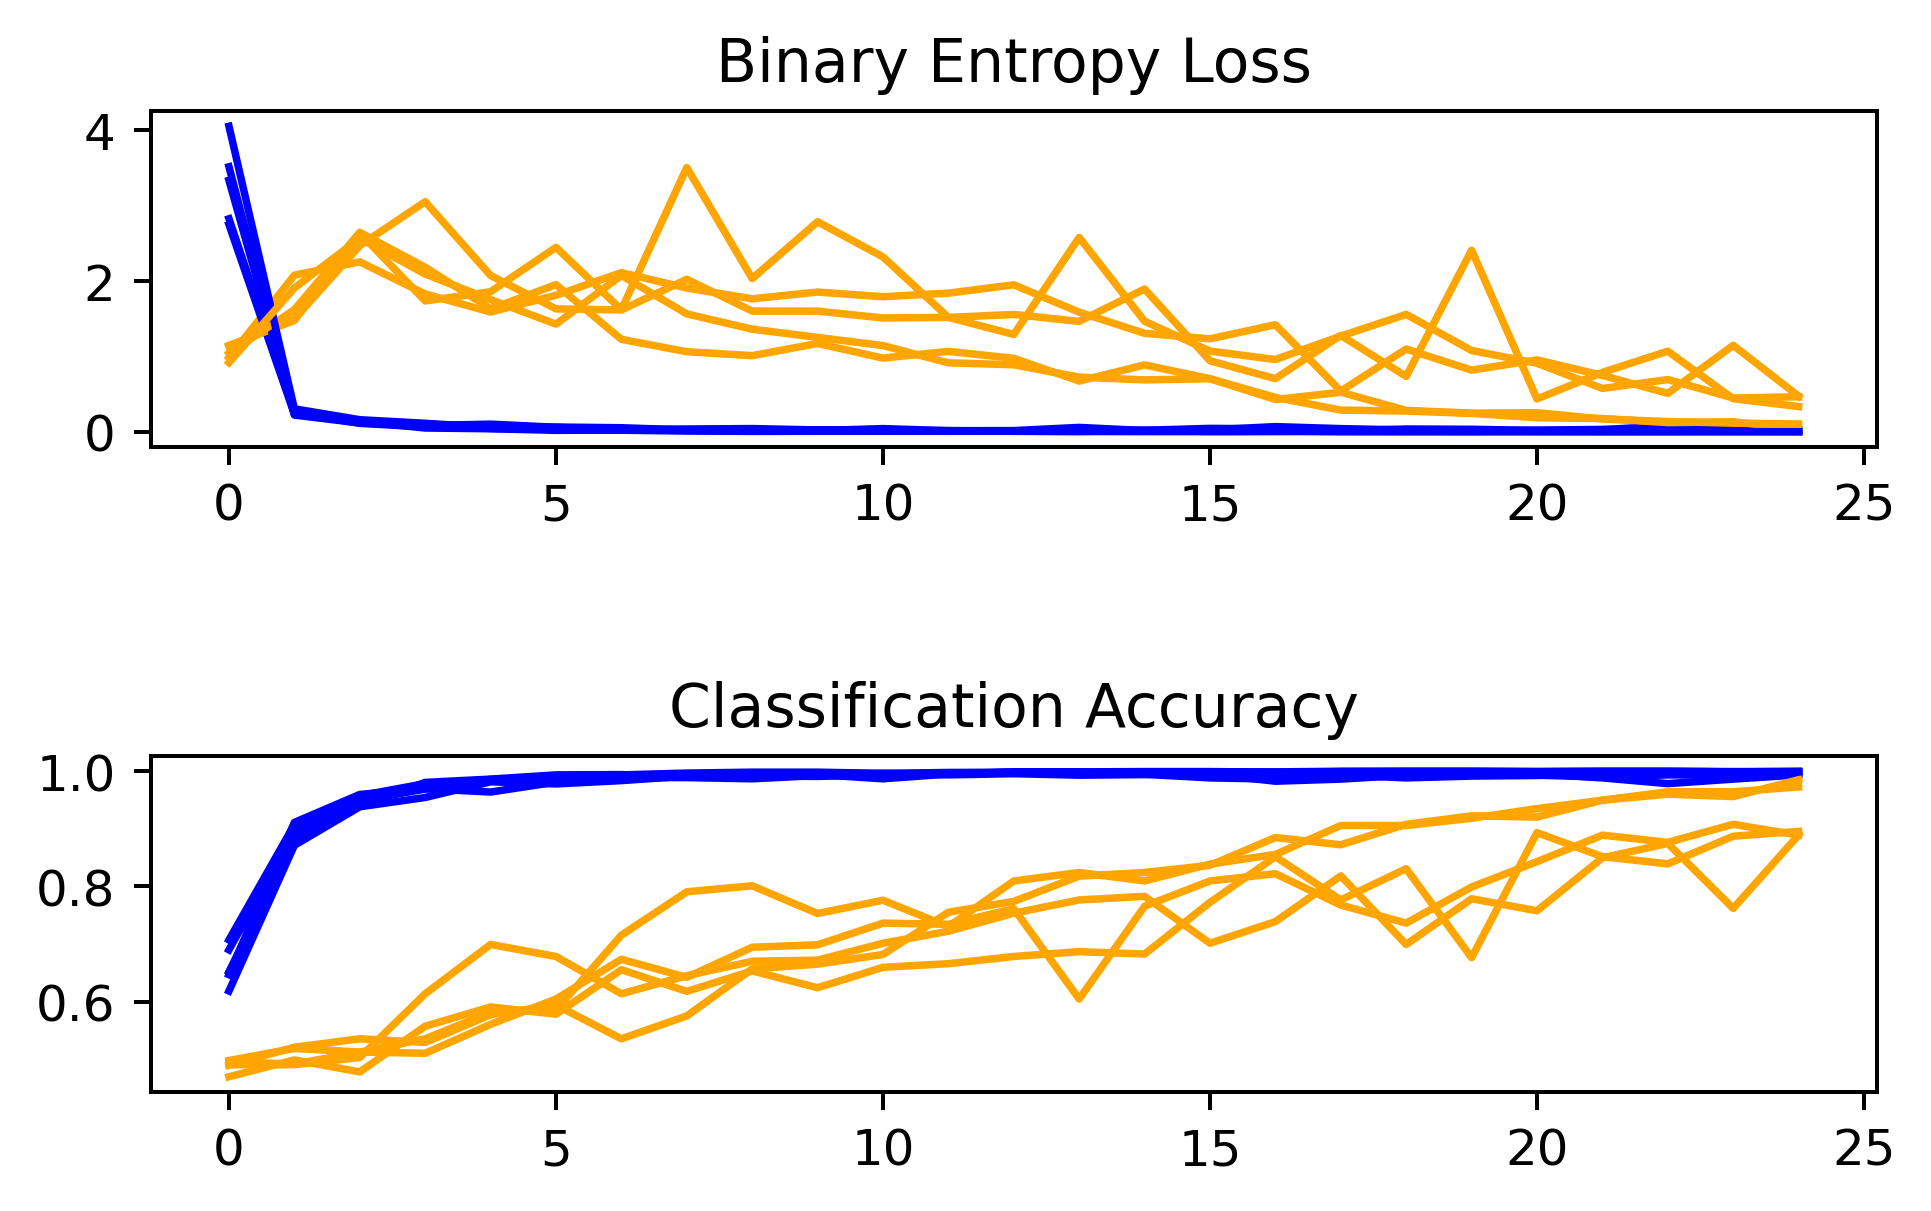

Accuracy: mean=92.645 std=4.322, n=5


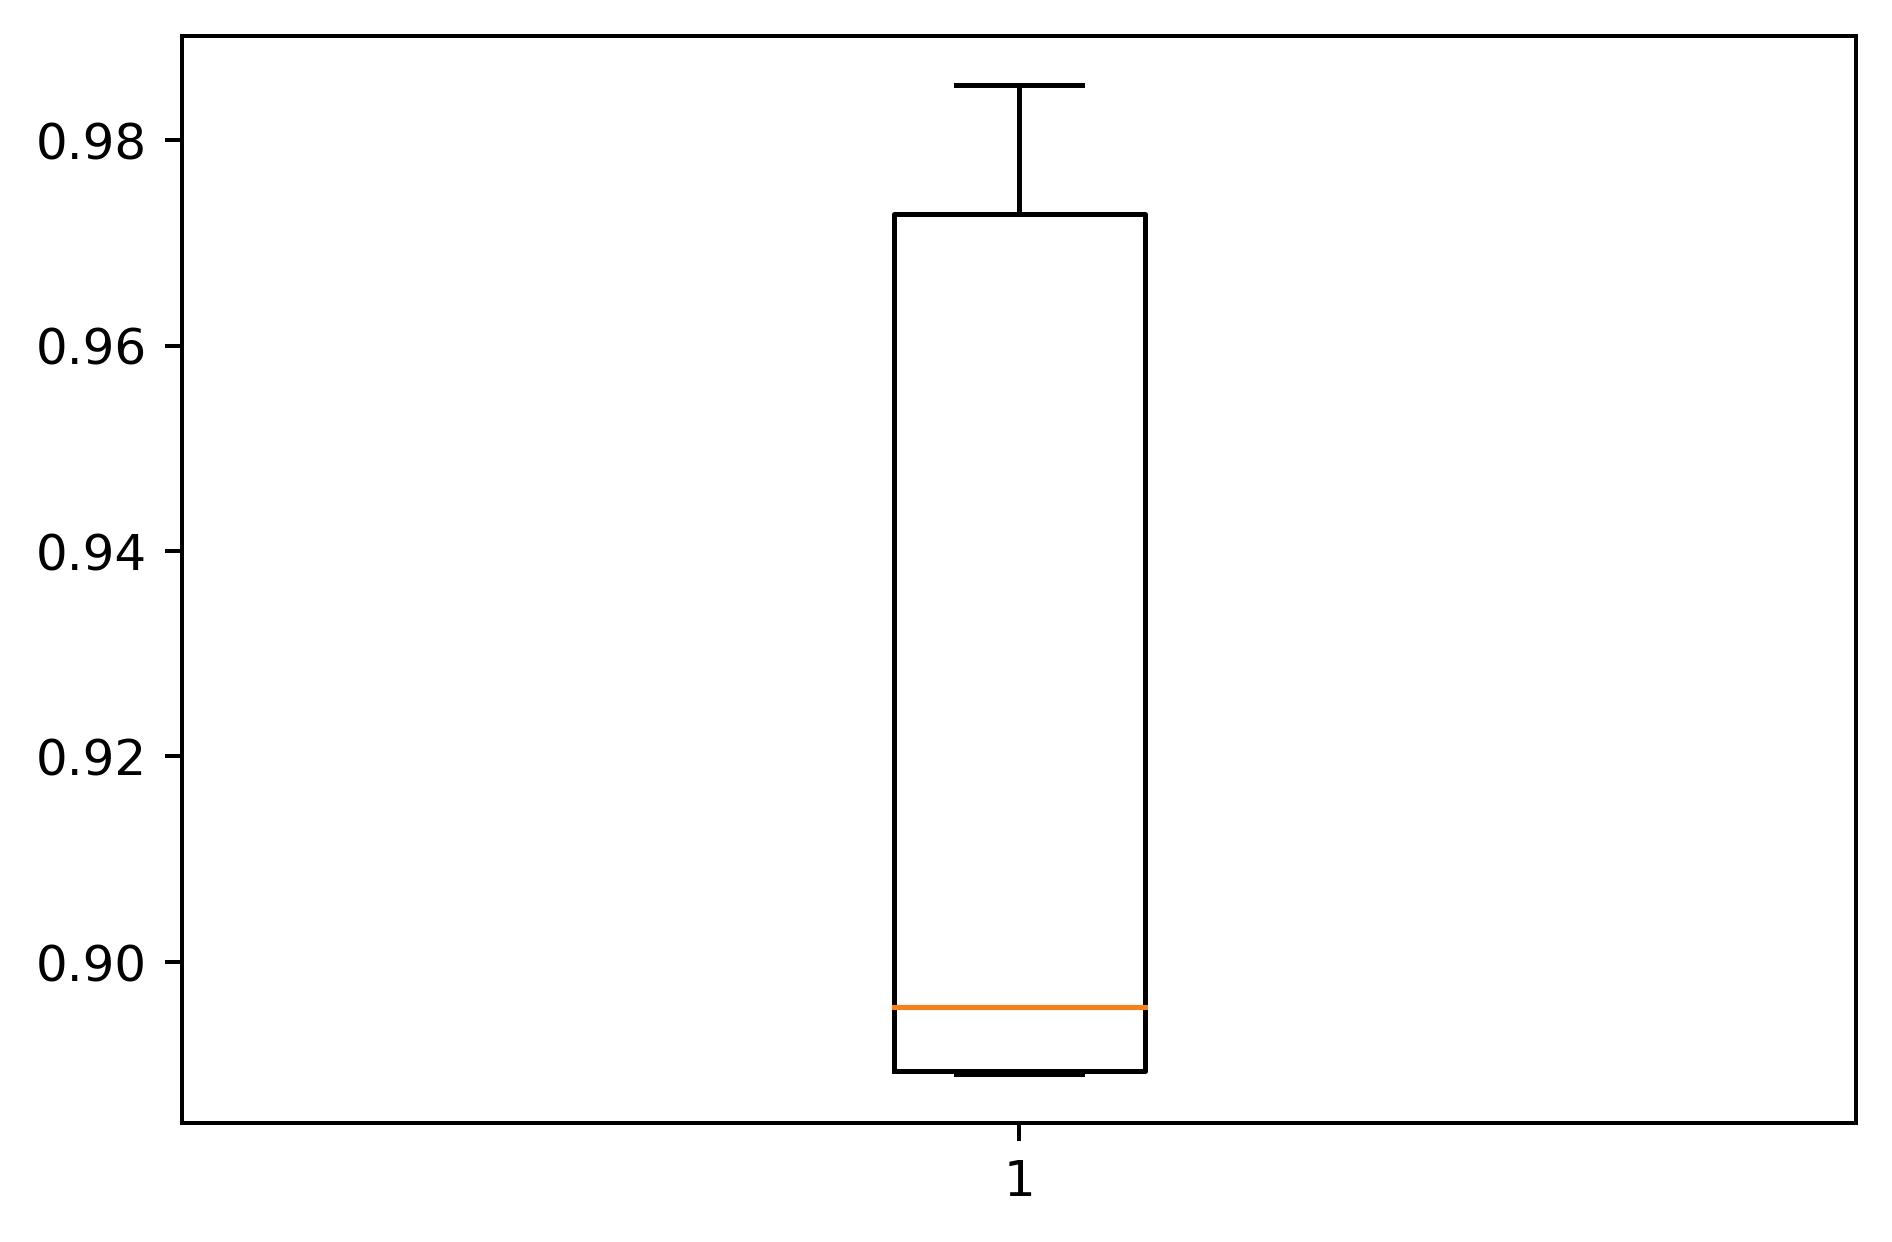

The overall accuracy is :0.9264498114585876


In [20]:
results()

There is a rather broad range of accuracies but the test accuracies do converge to the training accuracies as well as binary losses. Next, we will fit the model on the training set and predict on the test set employing early stopping on the entropy loss stopping if the loss does not improve for at least three consecutive iterations.

In [48]:
model = nn_model()

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.fit(trainX, trainY, epochs=25, batch_size=128, verbose=0, callbacks = [callback])

In [49]:
_, acc = model.evaluate(testX, testY, verbose=1)
acc

19/19 [==============================] - 1s 48ms/step - loss: 0.0723 - accuracy: 0.9883


0.9882746934890747

In [51]:
y_pred_test = model.predict(testX)
y_pred_test = (y_pred_test > 0.5)
type(y_pred_test)

numpy.ndarray

We will now return to normal display settings for the visualizing the confusion matrix.

In [32]:
plt.rcParams['figure.dpi'] = 80

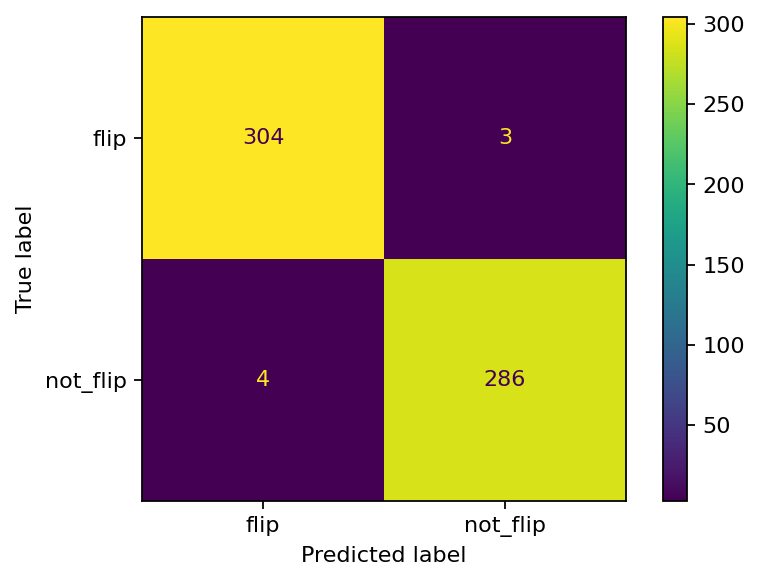

In [63]:
cm = confusion_matrix(testY, y_pred_test)
cmd = ConfusionMatrixDisplay(cm, display_labels=['flip','not_flip'])
cmd.plot()

plt.show()

In [53]:
print(classification_report(testY, y_pred_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       307
           1       0.99      0.99      0.99       290

    accuracy                           0.99       597
   macro avg       0.99      0.99      0.99       597
weighted avg       0.99      0.99      0.99       597



The f1 score in the classification report is excellent.  There were only 4 false positives and 3 false negatives.  We will make the assumption that a positive is a "flipped" page here.  Let's take a look at some of the images that were misclassified. We will employ a list comprehension to capture which prediction labels were not equal to the test set labels (i.e. which images were predicted to have a 0 or 1 where the actual label was a 0 instead of a 1 or vise versa.) 

In [64]:
false_negatives = [i for i in range(len(y_pred_test)) if y_pred_test[i] == 1 if testY[i] == 0]

In [65]:
false_negatives

[350, 460, 465]

In [66]:
false_positives = [i for i in range(len(y_pred_test)) if y_pred_test[i] == 0 if testY[i] == 1]

In [67]:
false_positives

[131, 146, 164, 171]

####**False Positives** - These images were classified as being flipped but were actually not labeled as flipped.

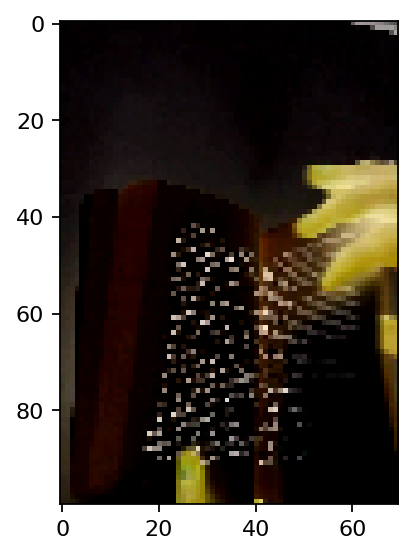

In [58]:
plt.imshow(testX[131])

Interesting as it clearly looks like the page has been flipped but the page is almost horizontal or flat to the surface. 

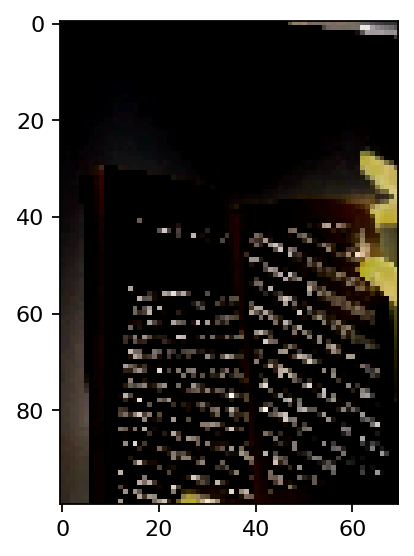

In [ ]:
plt.imshow(testX[146])

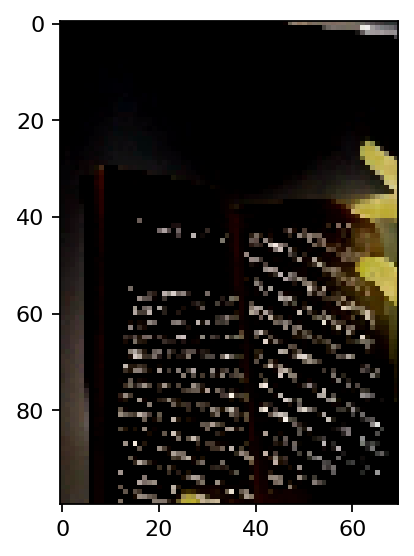

In [ ]:
plt.imshow(testX[164])

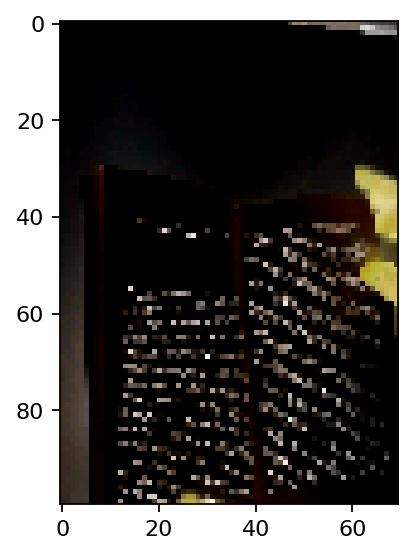

In [ ]:
plt.imshow(testX[171])

These three images are similar to our initial test image where a finger appears to be ready to flip the page but has not yet.  

####**False Negatives** - These images were classified as not being flipped but are actually labeled as being in the flipping process.

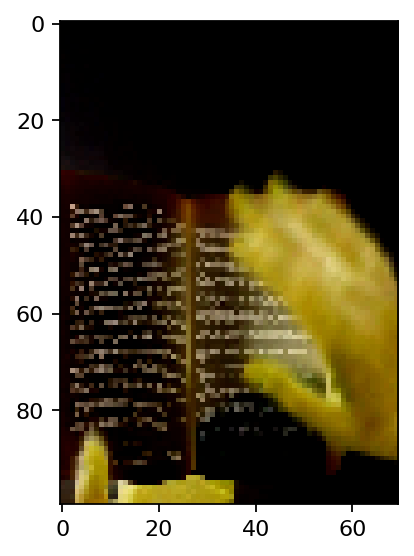

In [62]:
plt.imshow(testX[350])

It appears that the page is just about to be flipped and there is a large hand present.  The model may have detected the presence of a large amount of text.

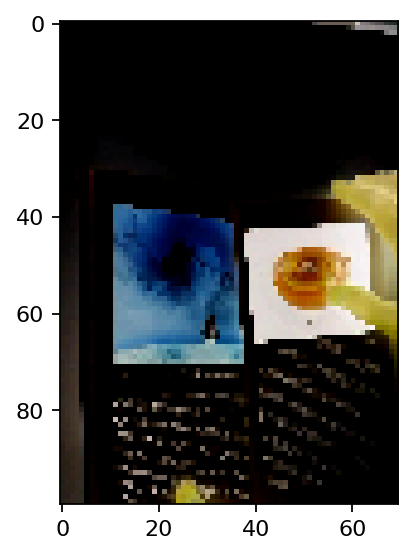

In [60]:
plt.imshow(testX[460])

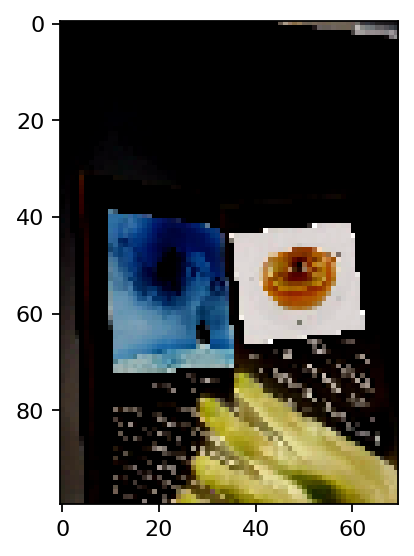

In [61]:
plt.imshow(testX[465])

These two images have rather large images present which may be what the model is detecting and classifying the image as not flipped. The first image of these two images is very similar to some of the false negatives in that there appears to fingers in the top right of the image that are preparing to flip the page.

###**Conclusion**

A convolutional neural network with Max 2-dimensional pooling, batch normalization and drop out layers was constructed to train on a set of images of book pages to determine whether a page was being flipped or not. The accuracy, precision, recall and f1-score are all at 99% on the test set after employing 5-fold cross-validation, early stoppping and drop out layers in the convolutional neural network model to control overfitting. Only 7 images were found to be misclassified and these images are very close to the instance in time where a page was either about to be flipped or a page is close to flat after flipping.  Some of these images also contain "hands" or images on the actual text that the model may recognize causing difficulties in classification.  This is due to the actual model being used to actually label the test images as flipped or not causing further ambiguity.  The majority of images in the training set are not flipped as the time instance of flipping is short.  Nonetheless, the constructed convolutional neural network predicted very well the flipped and non-flipped images in the test set.  Image preprocessing and the utilization of the Adam optimizer led to much higher metrics.